### Notebook to visualize FreeSurfer measaures on surfaces and parcellations

In [1]:
from brainspace.datasets import load_group_fc, load_parcellation, load_conte69
from brainspace.plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface
from nibabel.freesurfer.mghformat import load
import nibabel as nib
import numpy as np
import pandas as pd
from nilearn import datasets, surface, plotting
import seaborn as sns
from pathlib import Path

In [2]:
### Load data
current_release = "Oct_2024"
FS_version = "7.3.2" #"6.0.1" #"7.3.2"
session = "ses-01"
dataset = "qpn"


dataset_dir = f"/home/nikhil/projects/Parkinsons/{dataset}/"
release_dir = f"{dataset_dir}/releases/{current_release}/"
tabular_dir = f"{release_dir}/tabular/"

# Current nipoppy manifest
manifest_csv = f"{release_dir}/manifest.csv"

# demographics
demographics_csv = f"{tabular_dir}/demographics.csv"

# Dx
dx_csv = f"{tabular_dir}/assessments/diagnosis.csv"

# imaging derivatives
fs_space = "fsaverage5"
FS_dir = f"{dataset_dir}/derivatives/freesurfer/v{FS_version}"
# surf_dir = f"{FS_dir}/surfmaps/{session}/{fs_space}/"

# ROI stats
DKT_csv = "/home/nikhil/projects/Parkinsons/neuro_arch/analysis/IDP/qpn/Aug_2024/agg_dfs/CT_DKT_df.csv"

# Surface maps
FS_surf_dir = f"{FS_dir}/surfmaps/{session}/{fs_space}/"

# Results
figs_dir = f"{dataset_dir}/results/{session}/anat/figs/"
Path(f"{figs_dir}").mkdir(parents=True, exist_ok=True)

### Get analysis groups

In [3]:
dx_df = pd.read_csv(dx_csv)
dx_df = dx_df[dx_df["redcap_event_name"] == "Baseline (Arm 1: C-OPN)"]

control_participants = dx_df[dx_df["diagnosis_group_for_analysis"] == "control"]["participant_id"].unique()
PD_participants = dx_df[dx_df["diagnosis_group_for_analysis"] == "PD"]["participant_id"].unique()

print(f"Control: {len(control_participants)}")
print(f"PD: {len(PD_participants)}")

dx_df.head()

Control: 69
PD: 202


,participant_id,redcap_event_name,Parkinson's disease in opinion of treating neurologist / Maladie de Parkinson selon l'avis du neurologue traitant,Final impression / Impression finale,"Determined diagnosis: If score = 0, Parkinson's Disease (PD) If score = 1, Progressive Supranuclear Palsy (PSP) If score = 2, Multiple System Atrophy (MSA) If score = 3, Corticobasal Syndrome (CBS) If score = 4, Dementia with Lewy Bodies (DLB) If score = 5, Frontotemporal Dementia (FTD) If score = 6, Essential Tremor (ET) If score = 7, REM Sleep Behaviour Disorder (RBD)",diagnosis_certainty,diagnosis_group_for_analysis,diagnosis_age
0,MNI0028,Baseline (Arm 1: C-OPN),Unsure / Incertain,Uncertain / Incertain,NaN,Is not PD / N'est pas PD,unknown,55.85
1,MNI0056,Baseline (Arm 1: C-OPN),Yes / Oui,Meets exclusion criteria / Rencontre des critè...,0.0,PD in the opinion of the treating neurologist ...,PD,75.28
2,MNI0058,Baseline (Arm 1: C-OPN),Yes / Oui,Uncertain / Incertain,0.0,Meets MDS criteria for probable PD / Répond au...,PD,56.19
3,MNI0068,Baseline (Arm 1: C-OPN),NaN,NaN,0.0,Self-report / Auto-évaluation,PD,NaN
4,MNI0079,Baseline (Arm 1: C-OPN),Yes / Oui,Meets criteria for Parkinson's disease / Répon...,0.0,Meets MDS criteria for established PD / Répond...,PD,46.02


### Plot CT on surface
- e.g. lh_surf_concat_thickness_10mm.mgh

In [4]:
def read_FS_surf(FS_surf_dir,participant_id, meas="thickness", fwhm=10):
    """ Read freesurfer surfaces for a given participant and hemisphere """
    # sub-MNI0143_lh_surf_thickness_10mm.mgh

    surf_data = {}
    try:
        for hemi in ["lh", "rh"]:
            surf_file = f"{FS_surf_dir}/sub-{participant_id}_{hemi}_surf_{meas}_{fwhm}mm.mgh"
            surf_data[hemi] = nib.load(surf_file).get_fdata()
            surf_sum = np.sum(surf_data[hemi].flatten())

            # check if the surface is empty
            if surf_sum == 0:
                print(f"Empty surface for {participant_id} {hemi}")
                return None            
                    
        return surf_data
    
    except:
        print(f"Error reading {participant_id}")
        return None    
    


In [5]:
PD_surf_data_lh = []
PD_surf_data_rh = []
control_surf_data_lh = []
control_surf_data_rh = []

for participant_id in control_participants:
    surf_data = read_FS_surf(FS_surf_dir,participant_id)
    if surf_data is not None:    
        control_surf_data_lh.append(surf_data["lh"]) 
        control_surf_data_rh.append(surf_data["rh"]) 

for participant_id in PD_participants:
    surf_data = read_FS_surf(FS_surf_dir, participant_id)
    if surf_data is not None:
        PD_surf_data_lh.append(surf_data["lh"])
        PD_surf_data_rh.append(surf_data["rh"])

# Global averages for sanity checks
control_surf_lh_avg = np.mean(np.squeeze(control_surf_data_lh), axis=1)
control_surf_rh_avg = np.mean(np.squeeze(control_surf_data_rh), axis=1)

PD_surf_lh_avg = np.mean(np.squeeze(PD_surf_data_lh), axis=1)
PD_surf_rh_avg = np.mean(np.squeeze(PD_surf_data_rh), axis=1)

print(f"control_surf_lh_min_max: {np.min(control_surf_lh_avg)}, {np.max(control_surf_lh_avg)}")
print(f"control_surf_rh_min_max: {np.min(control_surf_rh_avg)}, {np.max(control_surf_rh_avg)}")

print(f"PD_surf_lh_min_max: {np.min(PD_surf_lh_avg)}, {np.max(PD_surf_lh_avg)}")
print(f"PD_surf_rh_min_max: {np.min(PD_surf_rh_avg)}, {np.max(PD_surf_rh_avg)}")


Empty surface for PD00457 rh
control_surf_lh_min_max: 2.0222456965845, 2.4360192031791446
control_surf_rh_min_max: 2.0511659587984603, 2.3993698642359096
PD_surf_lh_min_max: 1.9169495186025196, 2.3899566684586766
PD_surf_rh_min_max: 1.8730138226822703, 2.4012433538339586


/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

<Axes: ylabel='Count'>

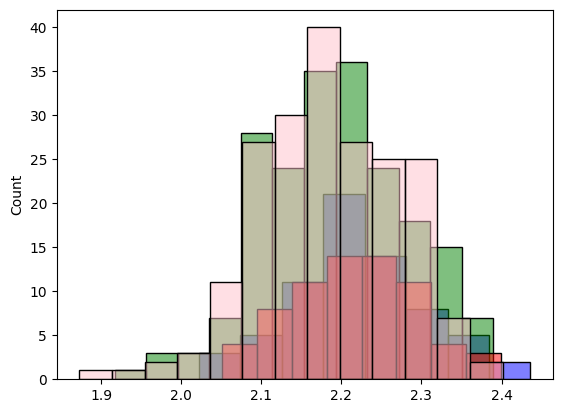

In [6]:
sns.histplot(control_surf_lh_avg.flatten(), color="blue", alpha=0.5)
sns.histplot(PD_surf_lh_avg.flatten(), color="green", alpha=0.5)
sns.histplot(control_surf_rh_avg.flatten(), color="red", alpha=0.5)
sns.histplot(PD_surf_rh_avg.flatten(), color="pink", alpha=0.5)


In [7]:
template_surface = "fsaverage5" # "fsaverage" or "fsaverage5"

if template_surface == "fsaverage":
    fsaverage_dir = f"{FS_dir}/output/ses-01/fsaverage/"
    annot_dir = f"{fsaverage_dir}/label/"
    
else:
    fsaverage_dir = "/home/nikhil/projects/neuroinformatics_tools/micapipe/surfaces/fsaverage5/"
    annot_dir = "/home/nikhil/projects/neuroinformatics_tools/micapipe/parcellations/"

surf_dir = f"{fsaverage_dir}/surf/"

pial_lh = read_surface(f"{surf_dir}/lh.pial", itype='fs')
pial_rh = read_surface(f"{surf_dir}/rh.pial", itype='fs')

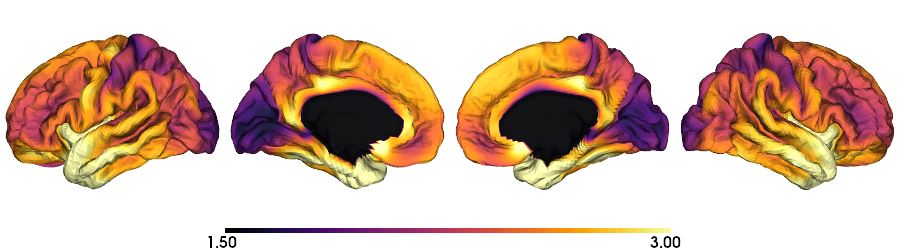

In [8]:
save_fig = False

# average across groups (axis = 0)
PD_surf_lh_avg = np.mean(np.squeeze(PD_surf_data_lh), axis=0)
PD_surf_rh_avg = np.mean(np.squeeze(PD_surf_data_rh), axis=0)

PD_surf_avg = [np.expand_dims(PD_surf_lh_avg, axis=(1)), np.expand_dims(PD_surf_rh_avg,axis=(1))]
PD_surf_avg = np.squeeze(np.concatenate(PD_surf_avg, axis=0))

if save_fig:
    save_file = f"{figs_dir}/CT_surf_PD.png"
else:
    save_file = None

# Plot the surfaces
plot_hemispheres( pial_lh, pial_rh, array_name=PD_surf_avg, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, 
                 interactive=True, share='both',layout_style="compact", #filename=save_file,
                 nan_color=(255, 255, 255, 1), color_range=(1.5, 3), cmap="inferno", transparent_bg=True)



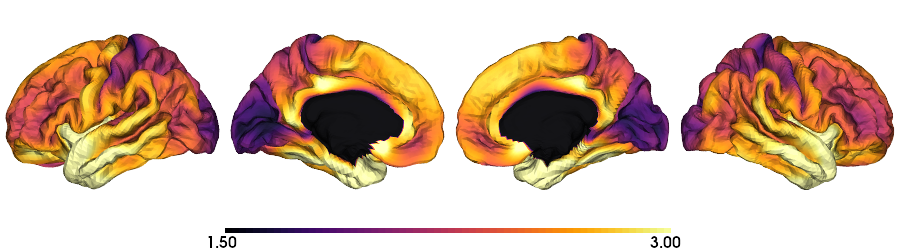

In [9]:
save_fig = False

# average across groups (axis = 0)
control_surf_lh_avg = np.mean(np.squeeze(control_surf_data_lh), axis=0)
control_surf_rh_avg = np.mean(np.squeeze(control_surf_data_rh), axis=0)

control_surf_avg = [np.expand_dims(control_surf_lh_avg, axis=(1)), np.expand_dims(control_surf_rh_avg,axis=(1))]
control_surf_avg = np.squeeze(np.concatenate(control_surf_avg, axis=0))

if save_fig:
    save_file = f"{figs_dir}/CT_surf_control.png"
else:
    save_file = None

# Plot the surfaces
plot_hemispheres( pial_lh, pial_rh, array_name=control_surf_avg, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, 
                 interactive=True, share='both',layout_style="compact", #filename=save_file,
                 nan_color=(255, 255, 255, 1), color_range=(1.5, 3), cmap="inferno", transparent_bg=True)



### Difference between CTRL and PD

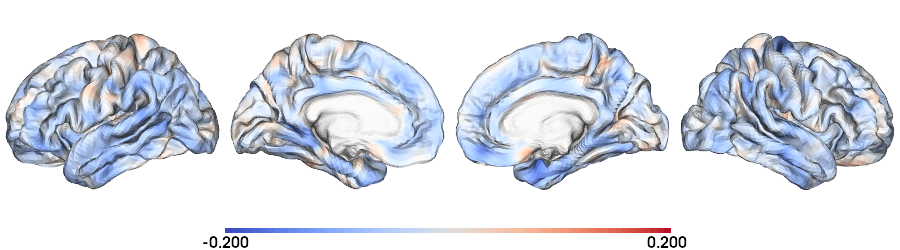

In [11]:
PD_minus_control_surf_avg = PD_surf_avg - control_surf_avg

# Plot the surfaces
plot_hemispheres( pial_lh, pial_rh, array_name=PD_minus_control_surf_avg, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, 
                 interactive=True, share='both',layout_style="compact",
                 nan_color=(255, 255, 255, 1), color_range=(-.2,.2), cmap="coolwarm", transparent_bg=True)



In [12]:
from enigmatoolbox.utils.parcellation import surface_to_parcel, parcel_to_surface
from enigmatoolbox.plotting import plot_cortical

print("control_surf_avg")
print(f"shape of surface: {control_surf_avg.shape}")
print(f"mean CT: {np.mean(control_surf_avg):3.2f}, min: {np.min(control_surf_avg):3.2f}, max: {np.max(control_surf_avg):3.2f}")

CT_aparc_fsa5 = surface_to_parcel(control_surf_avg, 'aparc_fsa5')

print("surface to parcel")
print(f"shape of parcels: {CT_aparc_fsa5.shape}")
print(f"mean CT: {np.mean(CT_aparc_fsa5):3.2f}, min: {np.min(CT_aparc_fsa5):3.2f}, max: {np.max(CT_aparc_fsa5):3.2f}")

CT_fsa5 = parcel_to_surface(CT_aparc_fsa5, 'aparc_fsa5')
print("parcel to surface")
print(f"shape of surface: {CT_fsa5.shape}")
print(f"mean CT: {np.mean(CT_fsa5):3.2f}, min: {np.min(CT_fsa5):3.2f}, max: {np.max(CT_fsa5):3.2f}")

# aparc_fsa5

control_surf_avg
shape of surface: (20484,)
mean CT: 2.22, min: 0.00, max: 4.07
surface to parcel
shape of parcels: (71,)
mean CT: 2.40, min: 0.31, max: 3.59
parcel to surface
shape of surface: (20484,)
mean CT: 2.22, min: 0.31, max: 3.59


In [13]:
plot_cortical(array_name=CT_fsa5, surface_name="fsa5", size=(800, 400),
              cmap='RdBu_r', color_bar=True, embed_nb=True, nan_color=(255, 255, 255, 1),
                 interactive=False, share='both',color_range=(-5,5),)

TypeError: memoryview: a bytes-like object is required, not 'BSVTKObjectWrapper'

### Plot average CT per parcel

In [ ]:
def get_mean_CT_per_parcel(labels, CT_vals, round_decimals=1):

    CT_parcel_df = pd.DataFrame()
    CT_parcel_df["CT"] = CT_vals
    CT_parcel_df["label"] = labels
    mean_CT_per_label_df = CT_parcel_df.groupby("label").mean().reset_index()
    label_CT_map_dict = dict(zip(mean_CT_per_label_df["label"], mean_CT_per_label_df["CT"]))
    CT_parcel_df["CT_parcel"] = CT_parcel_df["label"].replace(label_CT_map_dict)
    mean_CT_parcel = np.array(CT_parcel_df["CT_parcel"],dtype=np.float32).round(round_decimals)

    return mean_CT_parcel

### Controls

In [ ]:
# plot mean CT per parcel on surface
plot_array = get_mean_CT_per_parcel(labels, CTRL_surf)
cmap = "inferno"
plot_hemispheres(pial_lh, pial_rh, array_name=plot_array, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), cmap=cmap, transparent_bg=True,color_bar='bottom') #color_range=(1.5, 4)

### PD

In [ ]:
# plot mean CT per parcel on surface
plot_array = get_mean_CT_per_parcel(labels, PD_surf)
cmap = "inferno"
plot_hemispheres(pial_lh, pial_rh, array_name=plot_array, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), cmap=cmap, transparent_bg=True, color_bar='bottom') #color_range=(1.5, 4),

### Difference between CTRL and PD

In [ ]:
# plot mean CT per parcel on surface
plot_thresh = 0.05
diff_surf = surf_dict["CTRL"] - surf_dict["PD"]
diff_surf[(diff_surf < plot_thresh) & (diff_surf > -plot_thresh)] = 0

plot_array = get_mean_CT_per_parcel(labels, diff_surf, round_decimals=2)
color_range = (-max(abs(plot_array)), max(abs(plot_array)))
cmap = "coolwarm"
plot_hemispheres(pial_lh, pial_rh, array_name=plot_array, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), cmap=cmap, transparent_bg=True, color_bar='bottom',color_range=color_range)